In [42]:
import os
from IPython.display import display
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    auc
)

from sklearnex import patch_sklearn
import pickle
from imblearn.over_sampling import SMOTE

import optuna
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from lightgbm import early_stopping

FOLDER_TO_SAVE_MODELS = 'saved_models'


### Exploring and processing the data

In [6]:
# Reading the data 
df_orig = pd.read_csv('creditcard.csv')

In [7]:
# First glance at the dataset
df_orig.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Checking if we've got any missing value
df_orig.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
value_counts = df_orig['Class'].value_counts()
proportions = value_counts / len(df_orig)
pd.DataFrame({
    'Count': value_counts, 
    'Proportion': proportions
})

,Count,Proportion
Class,,
0,284315,0.998273
1,492,0.001727


We are dealing with an extremely imbalanced dataset, where only 0.17% of the transactions are fraudulant. It's really important to consider this class imbalance when building our model.

If I use the original data to calculate the correlation matrix, it will be influenced by the class imbalance, with non-fraud cases dominating the fraud cases. This could lead us to distorted results. 

In [10]:
# Oversampling the original data using the SMOTE algorithm
smote = SMOTE(random_state=1234)
X_smote, y_smote = smote.fit_resample(df_orig.drop(columns='Class'), df_orig['Class'])
df_smote = X_smote.join(y_smote)

Text(0.5, 1.05, 'Correlation heatmap:\noversampled data')

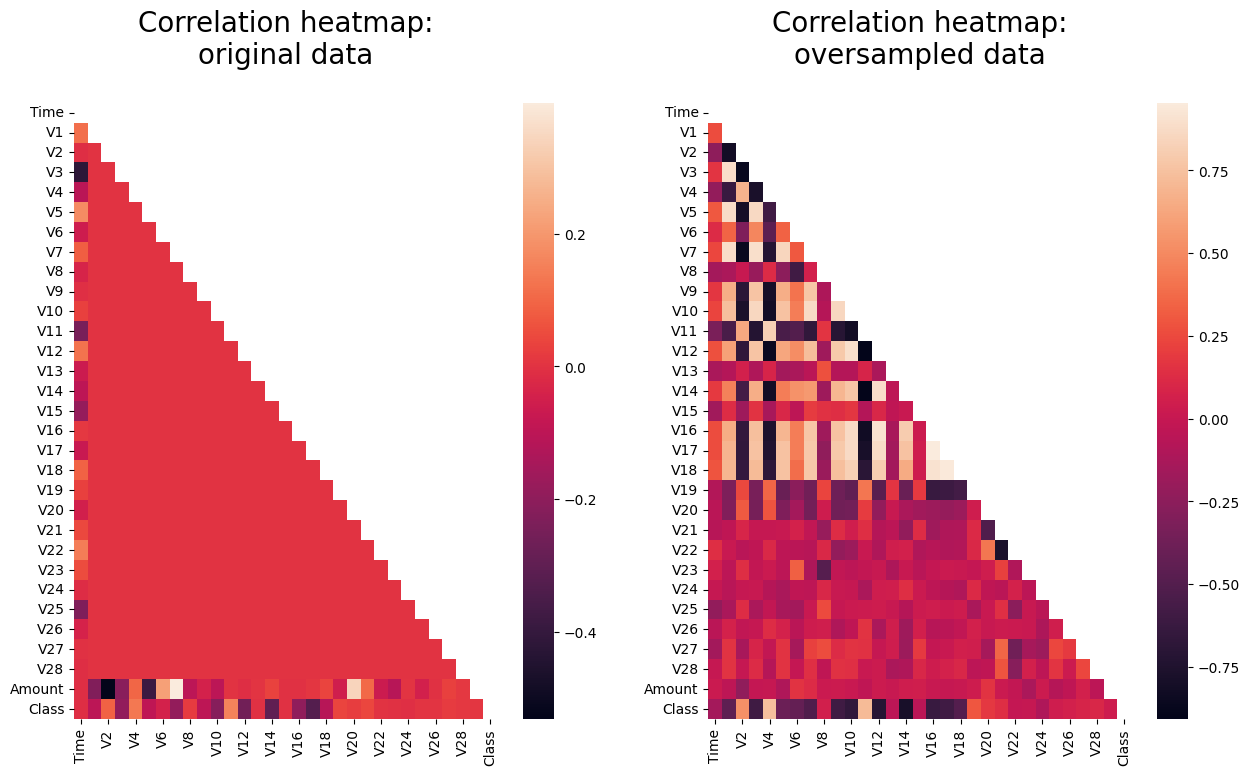

In [11]:
# Let's plot the correlation heatmaps for both the original data and the oversampled data.
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(15)
mask = np.triu(np.ones_like(df_orig.corr(), dtype=bool))
sns.heatmap(df_orig.corr(), mask = mask, ax=ax1)
ax1.set_title("Correlation heatmap:\noriginal data",fontsize=20, y=1.05)
sns.heatmap(df_smote.corr(), mask = mask, ax=ax2)
ax2.set_title("Correlation heatmap:\noversampled data",fontsize=20, y=1.05)

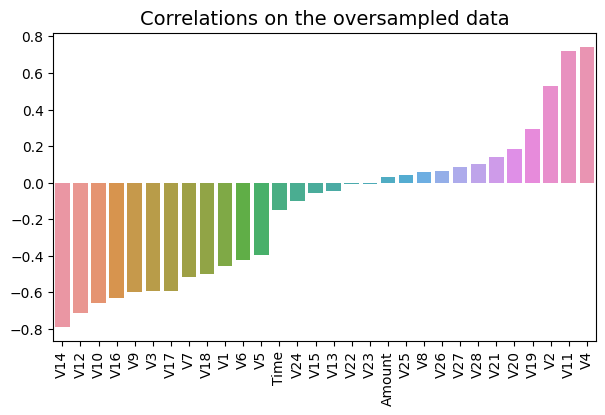

In [12]:
# Creating a pd Series containing the columns with their correlation values based on the oversampled dataset
correlations = df_smote.corr()['Class'].sort_values()
correlations = correlations.loc[correlations.index != 'Class']

# Plot the correlations on a barplot
plt.figure(figsize = (7,4))
plt.title('Correlations on the oversampled data',fontsize=14)
s = sns.barplot(y=correlations, x=correlations.index)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
s.set_ylabel("")
plt.show()  

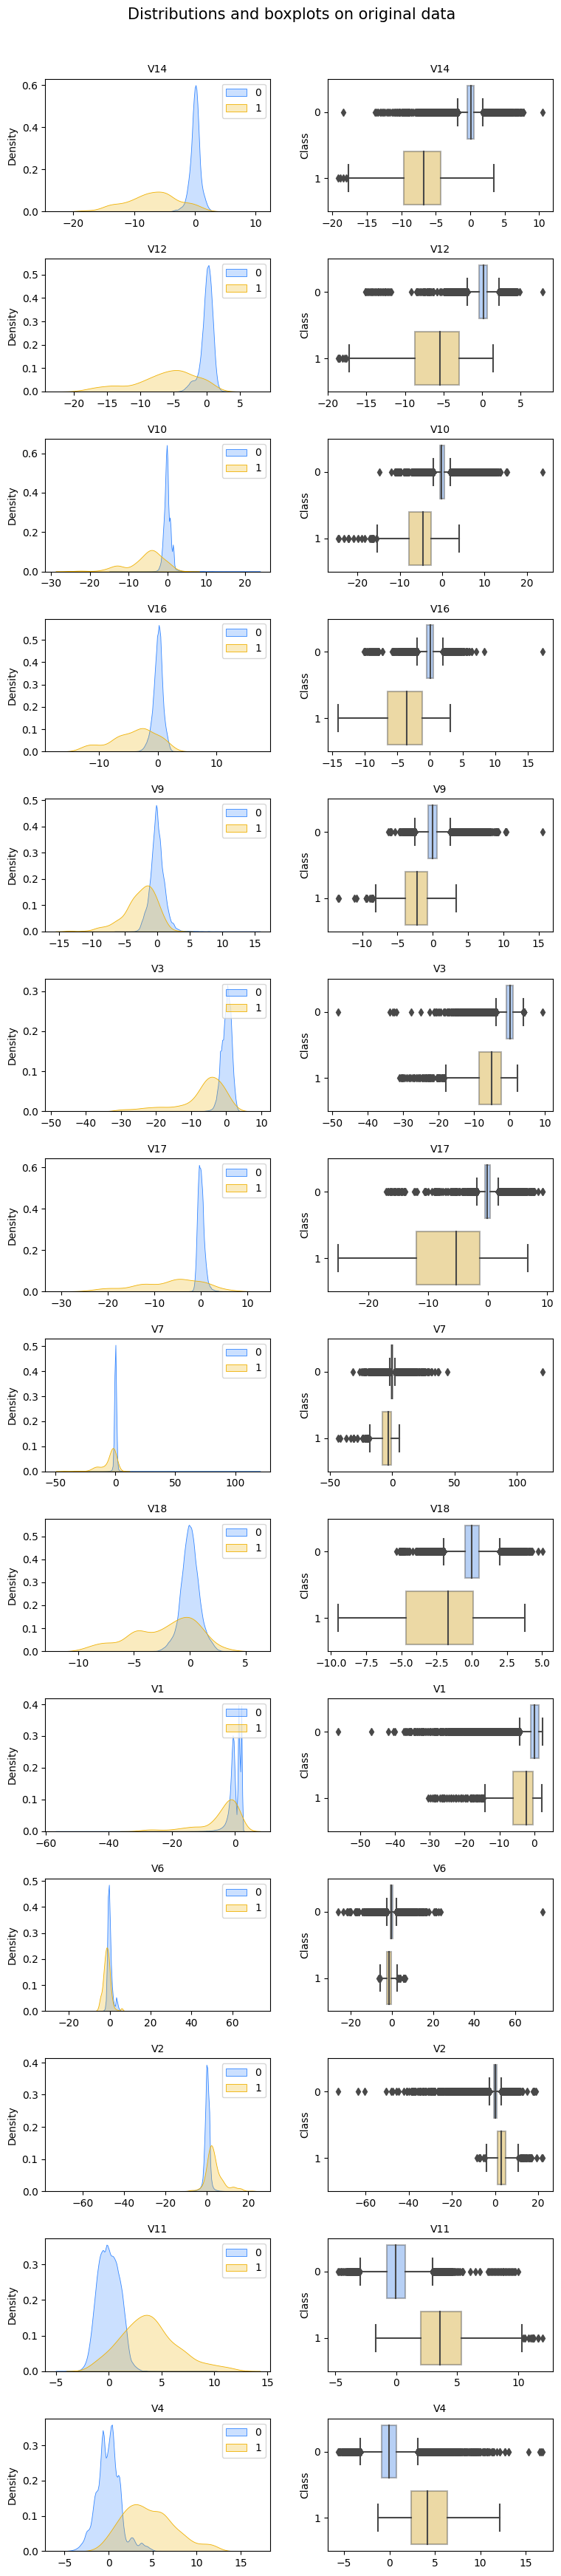

In [13]:
important_features = correlations[np.abs(correlations) > 0.4].index

f, axes = plt.subplots(len(important_features),2)
f.suptitle('Distributions and boxplots on original data',fontsize=15,y=1.0005)
f.set_figheight(2.5*len(important_features))
f.set_figwidth(8)
f.tight_layout(pad=2.5)

for i, feature in enumerate(important_features):

    sns.kdeplot(
        data = df_orig.loc[df_orig.Class == 0], 
        x = feature, 
        fill = True, 
        color ="#3386FF",
        linewidth=0.6, 
        ax=axes[i,0], 
        label=0
    )
    
    sns.kdeplot(
        data = df_orig.loc[df_orig.Class == 1], 
        x = feature, 
        fill = True, 
        color ="#EFB000",
        linewidth=0.6, 
        ax=axes[i,0], 
        label=1
    )
    
    axes[i,0].set_xlabel('')
    axes[i,0].legend()
    axes[i,0].set_title(feature,fontsize=10, y=1.00)


    sns.boxplot(x = df_orig[feature],
                y = df_orig['Class'],
                orient='h',
                palette= ["#3386FF","#EFB000"],
                ax=axes[i][1],
                boxprops=dict(alpha=.4)
    )
    axes[i,1].set_xlabel('')
    axes[i][1].set_title(feature,fontsize=10, y=1.00)


As the boxplots show us, our dataset contains several outliers. Removing these outliers would eliminate a significant number of observations from the fraud cases.

Additionally, this approach may lead to a loss of valuable information and potentially weaken the generalization capability of our model, i.e. it might achieve better results on this dataset but could perform poorly on unseen, real-life data.

Furthermore, considering the fact that we are working mostly with features that were transformed by PCA, I believe it is wiser to put the emphasis on building a robust model instead of trying to figure out what is considered to be an outlier. 

In [14]:
df = df_orig

X = df.drop(columns='Class')
y = df['Class']

In [15]:
# Splitting the dataset into a test and train set. 
# I will perform cross validation on the trainset, and eventually I will test on the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

Here, I am implementing some functions that will be used during the optimization and the evaluation process of our models."

In [16]:

def predict_threshold(threshold, model, x):
    """ 
    Make binary predictions based on the given threshold
    """

    return np.array([int(x[0] <threshold) for x in model.predict_proba(x)])


def optimize_objective(objective, n_trials, direction):
    """
    Optimize an objective function using Optuna.
    """
    
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return study


def evaluate_model(model, x_test, y_test):

    """
    Evaluate the model's performance on test data and print out and visualize some metrics.

    Returns:
    - results_df_diff_thresholds: A DataFrame containing metrics for different thresholds.
    - auc_precision_recall: Area Under the PR Curve (AUCPR).
    - lr_recall: Recall values for the Precision-Recall Curve.
    - lr_precision: Precision values for the Precision-Recall Curve.

    """

    # Get the results. 
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]


    # dictionary to store the metrics on different thresholds
    results_on_diff_threshold = {
        'threshold': [],
        'precision': [],
        'recall': [],
        'FN': [],
        'FP': [],
        'TP': [],
        'TN': [],
    }
    
    # loop trough the different thresholds and populate the results_on_diff_threshold dict
    for i in np.linspace(0.1,0.9,9):

        results_on_diff_threshold['threshold'].append(i)

        y_pred_threshold = predict_threshold(i,model, X_test)

        recall = recall_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)

        results_on_diff_threshold['precision'].append(precision)
        results_on_diff_threshold['recall'].append(recall)

        cm_threshold = confusion_matrix(y_test, y_pred_threshold)
        tn, fp, fn, tp = cm_threshold.ravel()

        results_on_diff_threshold['FN'].append(fn)
        results_on_diff_threshold['FP'].append(fp)
        results_on_diff_threshold['TP'].append(tp)
        results_on_diff_threshold['TN'].append(tn)

    # Getting the data for the PR curve
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # auc score
    auc_precision_recall = auc(lr_recall, lr_precision)

    results_df_diff_thresholds = pd.DataFrame(results_on_diff_threshold)

    # Printing out the results
    print("-------------------- Evaulation scores --------------------\n")
    print(classification_report(y_test, y_pred))
    print("-----------------------------------------------------------")
    print(f"AUCPR score: {auc_precision_recall:.4f}\n")
    print("-----------------------------------------------------------")
    print("Metrics when different threshold is used on test data: ")

    display(results_df_diff_thresholds)
    print("\n")

    plt.figure(figsize = (5,5))
    plt.plot(lr_recall, lr_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    return results_df_diff_thresholds, auc_precision_recall, lr_recall, lr_precision

### Random forest - optimized with RandomSearchCV 

In [17]:
# Enable the intel extension to boost performance in time
patch_sklearn(['RandomForestClassifier'])


class_weights = {1: np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])}

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500],
    'class_weight':[class_weights]
}



kfold = StratifiedKFold(n_splits=3)

model_rf = RandomizedSearchCV(
        RandomForestClassifier(n_jobs=-1),
        param_grid,
        cv=kfold,
        scoring= 'neg_log_loss',
        verbose=1,
        n_iter=30,
        random_state=42 
)


model_rf.fit(X_train, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=30,
                   param_distributions={'class_weight': [{1: 24.026793419648342}],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_log_loss', verbose=1)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8833

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.957143,0.683673,31,3,67,56861
1,0.2,0.961039,0.755102,24,3,74,56861
2,0.3,0.951220,0.795918,20,4,78,56860
3,0.4,0.910112,0.826531,17,8,81,56856
4,0.5,0.864583,0.846939,15,13,83,56851
5,0.6,0.850000,0.867347,13,15,85,56849
6,0.7,0.809524,0.867347,13,20,85,56844
7,0.8,0.761062,0.877551,12,27,86,56837
8,0.9,0.666667,0.897959,10,44,88,56820


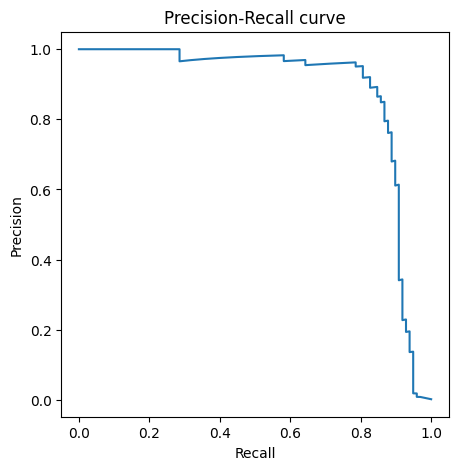

In [18]:
result_rf = evaluate_model(model_rf, X_test, y_test)

In [19]:
# Saving our model with the best performance

# Check if the folder exists
if not os.path.exists(FOLDER_TO_SAVE_MODELS):
    # If it doesn't exist, create the folder
    os.mkdir(FOLDER_TO_SAVE_MODELS)

filename = os.path.join(FOLDER_TO_SAVE_MODELS,f"Random-forest-{datetime.now().strftime('%Y%m%d')}.sav")
pickle.dump(model_rf, open(filename, 'wb'))

# Example to load rf model
# loaded_model_rf = pickle.load(open(filename, 'rb'))

### XGBOOST classifier - optimized with OPTUNA

In [20]:
def objective_xgb(
        trial,
        eval_metric='logloss',
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3,
):
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_test, label=y_test)

    pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

    param = {
        "verbosity":0,
        'objective':trial.suggest_categorical('objective',['binary:logistic']),
        "eval_metric": [eval_metric],
        'predictor': trial.suggest_categorical('predictor',['gpu_predictor']),
        'tree_method':trial.suggest_categorical('tree_method',['gpu_hist']),
        'lambda'           : trial.suggest_float('lambda', 1e-3, 5.0),
        'alpha'            : trial.suggest_float('alpha', 1e-3, 5.0),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 150),
        'subsample'        : trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'max_depth'        : trial.suggest_int("max_depth", 1, 9),
        'eta'    : trial.suggest_categorical('eta', [0.001,0.01,0.05,0.1,0.2,0.25,0.3]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight',[pos_weight])
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f"test-{eval_metric}")

    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        callbacks=[pruning_callback],
        nfold=n_folds,
        stratified=True,
        early_stopping_rounds=100,
        seed=seed,
        verbose_eval=False,
    )

    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))

    # Extract the best score.
    best_score = xgb_cv_results[f"test-{eval_metric}-mean"].values[-1]
    return best_score


In [48]:
study_xgb = optimize_objective(
    objective=objective_xgb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 20:27:37,274] A new study created in memory with name: no-name-d6b16355-3089-4deb-9f35-1039208c6839
[I 2023-10-12 20:27:38,497] Trial 0 finished with value: 0.008522642141949215 and parameters: {'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'lambda': 3.9685579753331828, 'alpha': 1.6214698839502322, 'min_child_weight': 76, 'subsample': 0.22385338043897207, 'colsample_bytree': 0.2312632863240107, 'max_depth': 5, 'eta': 0.25, 'scale_pos_weight': 24.026793419648342}. Best is trial 0 with value: 0.008522642141949215.
[I 2023-10-12 20:27:47,940] Trial 1 finished with value: 0.0034088673487403637 and parameters: {'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'lambda': 4.926213867034778, 'alpha': 4.827641795562912, 'min_child_weight': 93, 'subsample': 0.9541450925669392, 'colsample_bytree': 0.4494453512690106, 'max_depth': 2, 'eta': 0.3, 'scale_pos_weight': 24.026793419648342}. Best is trial 1 w

Number of finished trials:  30
Best trial:
  Value: 0.002729423755974963
  Params: 
    objective: binary:logistic
    predictor: gpu_predictor
    tree_method: gpu_hist
    lambda: 0.8399003907995732
    alpha: 1.9142074068887265
    min_child_weight: 16
    subsample: 0.9072545018344723
    colsample_bytree: 0.7865540487366641
    max_depth: 9
    eta: 0.25
    scale_pos_weight: 24.026793419648342


In [49]:
optuna.visualization.plot_optimization_history(study_xgb)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.85      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8932

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.952381,0.816327,18,4,80,56860
1,0.2,0.941860,0.826531,17,5,81,56859
2,0.3,0.931034,0.826531,17,6,81,56858
3,0.4,0.920455,0.826531,17,7,81,56857
4,0.5,0.922222,0.846939,15,7,83,56857
5,0.6,0.904255,0.867347,13,9,85,56855
6,0.7,0.885417,0.867347,13,11,85,56853
7,0.8,0.858586,0.867347,13,14,85,56850
8,0.9,0.741379,0.877551,12,30,86,56834


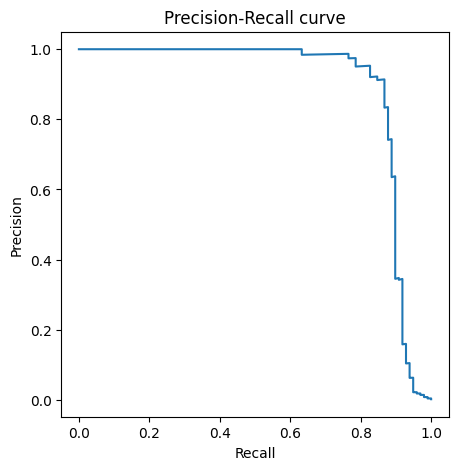

In [50]:
def create_fit_xgb(study, x, y):

    model = xgb.XGBClassifier(
        **study.best_params, 
        n_estimators = study.best_trial.user_attrs['n_estimators']
    )
    model.fit(x, y)

    return model

model_xgb = create_fit_xgb(study_xgb, X_train, y_train)
result_xgb = evaluate_model(model_xgb, X_test, y_test)

In [51]:
# Saving the model with the best performance
model_xgb.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"XGB-{datetime.now().strftime('%Y%m%d')}.json"))

# Example to load model
# loaded_model_xgb = xgb.XGBClassifier()
# loaded_model_xgb.load_model("model_sklearn.json")

### CATBOOST + OPTUNA

In [25]:
def objective_cb(
        trial,
        eval_metric='Logloss', 
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3
):
    
        train_pool = cb.Pool(data=x_train, label=y_train, has_header=True)
        test_pool = cb.Pool(data=x_test, label=y_test, has_header=True)

        pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

        params = {
                "objective": trial.suggest_categorical("objective", ["Logloss"]),
                # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
                "depth": trial.suggest_int("depth", 1, 12),
                "learning_rate":trial.suggest_float("learning_rate", 1e-3, 1, log=True),
                # With this amount of data ordered boosting_type would make our training 
                "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
                "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
                ),
                "scale_pos_weight": trial.suggest_categorical('scale_pos_weight',[pos_weight]),
                "task_type":trial.suggest_categorical("task_type",["GPU"]),
                "verbose": False

        }

        if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1)


        catboost_cv_results = cb.cv(train_pool,
                params,
                nfold=n_folds,
                stratified=True,
                early_stopping_rounds=100,
                seed=seed,
                verbose=0
                
        )


        # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
        trial.set_user_attr("iterations", len(catboost_cv_results))

        # Extract the best score.
        best_score = catboost_cv_results[F"test-{eval_metric}-mean"].values[-1]
        return best_score


In [26]:
study_cb = optimize_objective(
    objective=objective_cb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 20:03:26,117] A new study created in memory with name: no-name-7995bcc9-2881-4b7e-94e6-9a308bdae6df


Training on fold [0/3]
bestTest = 0.03679118235
bestIteration = 9
Training on fold [1/3]
bestTest = 0.03203575024
bestIteration = 18
Training on fold [2/3]


[I 2023-10-12 20:03:27,201] Trial 0 finished with value: 0.04049479430295511 and parameters: {'objective': 'Logloss', 'depth': 4, 'learning_rate': 0.41983931699271126, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 0 with value: 0.04049479430295511.


bestTest = 0.0451583901
bestIteration = 18
Training on fold [0/3]
bestTest = 0.03801185538
bestIteration = 146
Training on fold [1/3]
bestTest = 0.02779794509
bestIteration = 232
Training on fold [2/3]


[I 2023-10-12 20:03:32,588] Trial 1 finished with value: 0.038682096724248244 and parameters: {'objective': 'Logloss', 'depth': 8, 'learning_rate': 0.013703764035865762, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 1 with value: 0.038682096724248244.


bestTest = 0.04641538271
bestIteration = 164
Training on fold [0/3]
bestTest = 0.05206469559
bestIteration = 999
Training on fold [1/3]
bestTest = 0.04726213369
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 20:03:37,559] Trial 2 finished with value: 0.05484542965687165 and parameters: {'objective': 'Logloss', 'depth': 2, 'learning_rate': 0.0014028365210425793, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 1 with value: 0.038682096724248244.


bestTest = 0.06520945969
bestIteration = 999
Training on fold [0/3]
bestTest = 0.0450860459
bestIteration = 2
Training on fold [1/3]
bestTest = 0.02983799809
bestIteration = 3
Training on fold [2/3]


[I 2023-10-12 20:03:38,758] Trial 3 finished with value: 0.07775953626077904 and parameters: {'objective': 'Logloss', 'depth': 6, 'learning_rate': 0.6031505894571851, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.3696628033470549}. Best is trial 1 with value: 0.038682096724248244.


bestTest = 0.05091431619
bestIteration = 1
Training on fold [0/3]
bestTest = 0.04192253841
bestIteration = 11
Training on fold [1/3]
bestTest = 0.0278435086
bestIteration = 13
Training on fold [2/3]


[I 2023-10-12 20:03:39,886] Trial 4 finished with value: 0.06295286331421385 and parameters: {'objective': 'Logloss', 'depth': 5, 'learning_rate': 0.38845582189400174, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.4972640450726826}. Best is trial 1 with value: 0.038682096724248244.


bestTest = 0.04466254646
bestIteration = 14
Training on fold [0/3]
bestTest = 0.04012045444
bestIteration = 149
Training on fold [1/3]
bestTest = 0.03385841425
bestIteration = 57
Training on fold [2/3]


[I 2023-10-12 20:03:41,270] Trial 5 finished with value: 0.04205644476339443 and parameters: {'objective': 'Logloss', 'depth': 1, 'learning_rate': 0.70226540183054, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 8.177643461489446}. Best is trial 1 with value: 0.038682096724248244.


bestTest = 0.05093108289
bestIteration = 260
Training on fold [0/3]
bestTest = 0.03553949277
bestIteration = 714
Training on fold [1/3]
bestTest = 0.02818819838
bestIteration = 819
Training on fold [2/3]


[I 2023-10-12 20:04:46,287] Trial 6 finished with value: 0.036054015156078985 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.002746140053818411, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.22477467747874796}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.0436250607
bestIteration = 582
Training on fold [0/3]
bestTest = 0.03718327341
bestIteration = 248
Training on fold [1/3]
bestTest = 0.02871557196
bestIteration = 421
Training on fold [2/3]


[I 2023-10-12 20:05:08,157] Trial 7 finished with value: 0.03701688449053611 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.012732325898361891, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04367298632
bestIteration = 258
Training on fold [0/3]
bestTest = 0.03799929732
bestIteration = 999
Training on fold [1/3]
bestTest = 0.03075344834
bestIteration = 998
Training on fold [2/3]


[I 2023-10-12 20:05:13,784] Trial 8 finished with value: 0.03846493501503059 and parameters: {'objective': 'Logloss', 'depth': 2, 'learning_rate': 0.00443065682039429, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.2141006684220558}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04664168837
bestIteration = 999
Training on fold [0/3]
bestTest = 0.04592486163
bestIteration = 999
Training on fold [1/3]
bestTest = 0.04336781872
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 20:05:28,139] Trial 9 finished with value: 0.04727677585124478 and parameters: {'objective': 'Logloss', 'depth': 7, 'learning_rate': 0.0010630261858203547, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.7998263962961462}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.0525376472
bestIteration = 999
Training on fold [0/3]
bestTest = 0.03439884147
bestIteration = 23
Training on fold [1/3]
bestTest = 0.02823117407
bestIteration = 28
Training on fold [2/3]


[I 2023-10-12 20:05:48,783] Trial 10 finished with value: 0.0493057141745033 and parameters: {'objective': 'Logloss', 'depth': 12, 'learning_rate': 0.06599545195694427, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 1.350412900712815}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04569071051
bestIteration = 20
Training on fold [0/3]
bestTest = 0.03666920251
bestIteration = 414
Training on fold [1/3]
bestTest = 0.02831831888
bestIteration = 529
Training on fold [2/3]


[I 2023-10-12 20:06:35,141] Trial 11 finished with value: 0.036987090756581555 and parameters: {'objective': 'Logloss', 'depth': 12, 'learning_rate': 0.007654515940438629, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04516663896
bestIteration = 480
Training on fold [0/3]
bestTest = 0.03703264771
bestIteration = 477
Training on fold [1/3]
bestTest = 0.02763875262
bestIteration = 726
Training on fold [2/3]


[I 2023-10-12 20:07:06,888] Trial 12 finished with value: 0.037095435585088855 and parameters: {'objective': 'Logloss', 'depth': 10, 'learning_rate': 0.0036067905242431193, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04534706575
bestIteration = 474
Training on fold [0/3]
bestTest = 0.03568396152
bestIteration = 674
Training on fold [1/3]
bestTest = 0.02785579532
bestIteration = 986
Training on fold [2/3]


[I 2023-10-12 20:07:29,395] Trial 13 finished with value: 0.03606601888088252 and parameters: {'objective': 'Logloss', 'depth': 9, 'learning_rate': 0.003692822784078185, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.13507281480789324}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04425922114
bestIteration = 517
Training on fold [0/3]
bestTest = 0.0358183387
bestIteration = 995
Training on fold [1/3]
bestTest = 0.02849962374
bestIteration = 995
Training on fold [2/3]


[I 2023-10-12 20:07:57,137] Trial 14 finished with value: 0.03618534130011565 and parameters: {'objective': 'Logloss', 'depth': 9, 'learning_rate': 0.0023967653583284636, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.17938030901571955}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04408646195
bestIteration = 817
Training on fold [0/3]
bestTest = 0.03582312331
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02862094196
bestIteration = 997
Training on fold [2/3]


[I 2023-10-12 20:08:23,687] Trial 15 finished with value: 0.036290923801767204 and parameters: {'objective': 'Logloss', 'depth': 9, 'learning_rate': 0.002445934063962989, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.10665280182514242}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04429356768
bestIteration = 749
Training on fold [0/3]
bestTest = 0.0358100769
bestIteration = 55
Training on fold [1/3]
bestTest = 0.02800271344
bestIteration = 72
Training on fold [2/3]


[I 2023-10-12 20:08:31,616] Trial 16 finished with value: 0.04168250149230634 and parameters: {'objective': 'Logloss', 'depth': 10, 'learning_rate': 0.03317502963996134, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.3578635653607888}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.044513124
bestIteration = 52
Training on fold [0/3]
bestTest = 0.04750548722
bestIteration = 999
Training on fold [1/3]
bestTest = 0.04392972743
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 20:08:48,337] Trial 17 finished with value: 0.047979704009036485 and parameters: {'objective': 'Logloss', 'depth': 8, 'learning_rate': 0.0010224561490527477, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.28786695592712785}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.05250389737
bestIteration = 999
Training on fold [0/3]
bestTest = 0.03591250719
bestIteration = 298
Training on fold [1/3]
bestTest = 0.02809657668
bestIteration = 337
Training on fold [2/3]


[I 2023-10-12 20:09:21,789] Trial 18 finished with value: 0.037096909331050955 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.005563328722917615, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 9.624616640705085}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04425473806
bestIteration = 235
Training on fold [0/3]
bestTest = 0.03631910355
bestIteration = 998
Training on fold [1/3]
bestTest = 0.0298689746
bestIteration = 998
Training on fold [2/3]


[I 2023-10-12 20:09:34,116] Trial 19 finished with value: 0.03708601023074673 and parameters: {'objective': 'Logloss', 'depth': 7, 'learning_rate': 0.002307853224895694, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.1344307193687746}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04504463128
bestIteration = 997
Training on fold [0/3]
bestTest = 0.03504562049
bestIteration = 215
Training on fold [1/3]
bestTest = 0.02852989842
bestIteration = 282
Training on fold [2/3]


[I 2023-10-12 20:09:49,562] Trial 20 finished with value: 0.037219857952084365 and parameters: {'objective': 'Logloss', 'depth': 10, 'learning_rate': 0.009258324468375998, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.514394954794066}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04323082829
bestIteration = 169
Training on fold [0/3]
bestTest = 0.03606495339
bestIteration = 998
Training on fold [1/3]
bestTest = 0.02908693449
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 20:10:14,676] Trial 21 finished with value: 0.03648080317681682 and parameters: {'objective': 'Logloss', 'depth': 9, 'learning_rate': 0.0022102505111340543, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.10984832543174643}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04410743965
bestIteration = 868
Training on fold [0/3]
bestTest = 0.03568271283
bestIteration = 591
Training on fold [1/3]
bestTest = 0.02825795813
bestIteration = 690
Training on fold [2/3]


[I 2023-10-12 20:10:32,638] Trial 22 finished with value: 0.036191484744033074 and parameters: {'objective': 'Logloss', 'depth': 9, 'learning_rate': 0.003928571086066817, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.22377576081252712}. Best is trial 6 with value: 0.036054015156078985.


bestTest = 0.04391557947
bestIteration = 470
Training on fold [0/3]
bestTest = 0.03553383036
bestIteration = 933
Training on fold [1/3]
bestTest = 0.02817109468
bestIteration = 995
Training on fold [2/3]


[I 2023-10-12 20:11:49,480] Trial 23 finished with value: 0.03574281909299948 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.002005985487276965, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.2708735271730777}. Best is trial 23 with value: 0.03574281909299948.


bestTest = 0.04307853048
bestIteration = 817
Training on fold [0/3]
bestTest = 0.03561345338
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02946295016
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 20:13:09,022] Trial 24 finished with value: 0.03616272704331808 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.001551039422769804, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.32509883404475315}. Best is trial 23 with value: 0.03574281909299948.


bestTest = 0.04339152337
bestIteration = 961
Training on fold [0/3]
bestTest = 0.03508449702
bestIteration = 301
Training on fold [1/3]
bestTest = 0.02806894238
bestIteration = 366
Training on fold [2/3]


[I 2023-10-12 20:14:13,318] Trial 25 finished with value: 0.03599936248314548 and parameters: {'objective': 'Logloss', 'depth': 12, 'learning_rate': 0.005355749156051682, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 0.7426340887142473}. Best is trial 23 with value: 0.03574281909299948.


bestTest = 0.04258702769
bestIteration = 267
Number of finished trials:  26
Best trial:
  Value: 0.03574281909299948
  Params: 
    objective: Logloss
    depth: 11
    learning_rate: 0.002005985487276965
    boosting_type: Plain
    bootstrap_type: Bernoulli
    scale_pos_weight: 24.026793419648342
    task_type: GPU
    subsample: 0.2708735271730777


In [45]:
optuna.visualization.plot_optimization_history(study_cb)

In [28]:
def create_fit_cb(study, x, y):

    model = cb.CatBoostClassifier(
        **study.best_params,
        iterations=study_cb.best_trial.user_attrs['iterations']
    )
    model.fit(x, y,verbose=True)

    return model


model_cb = create_fit_cb(study_cb, X_train, y_train)

0:	learn: 0.6871287	total: 29.5ms	remaining: 29.5s
1:	learn: 0.6813359	total: 55.7ms	remaining: 27.8s
2:	learn: 0.6758410	total: 82.5ms	remaining: 27.4s
3:	learn: 0.6700145	total: 110ms	remaining: 27.3s
4:	learn: 0.6647412	total: 136ms	remaining: 27.1s
5:	learn: 0.6584795	total: 163ms	remaining: 26.9s
6:	learn: 0.6527243	total: 189ms	remaining: 26.8s
7:	learn: 0.6467978	total: 216ms	remaining: 26.8s
8:	learn: 0.6417726	total: 242ms	remaining: 26.6s
9:	learn: 0.6357191	total: 269ms	remaining: 26.6s
10:	learn: 0.6292738	total: 295ms	remaining: 26.5s
11:	learn: 0.6245087	total: 321ms	remaining: 26.5s
12:	learn: 0.6192647	total: 349ms	remaining: 26.5s
13:	learn: 0.6134441	total: 376ms	remaining: 26.5s
14:	learn: 0.6083792	total: 403ms	remaining: 26.5s
15:	learn: 0.6024945	total: 429ms	remaining: 26.4s
16:	learn: 0.5973784	total: 457ms	remaining: 26.4s
17:	learn: 0.5924612	total: 483ms	remaining: 26.3s
18:	learn: 0.5874713	total: 509ms	remaining: 26.3s
19:	learn: 0.5824972	total: 536ms	rema

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.86      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8839

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.855556,0.785714,21,13,77,56851
1,0.2,0.847826,0.795918,20,14,78,56850
2,0.3,0.847826,0.795918,20,14,78,56850
3,0.4,0.843750,0.826531,17,15,81,56849
4,0.5,0.840000,0.857143,14,16,84,56848
5,0.6,0.831683,0.857143,14,17,84,56847
6,0.7,0.801887,0.867347,13,21,85,56843
7,0.8,0.743590,0.887755,11,30,87,56834
8,0.9,0.640288,0.908163,9,50,89,56814


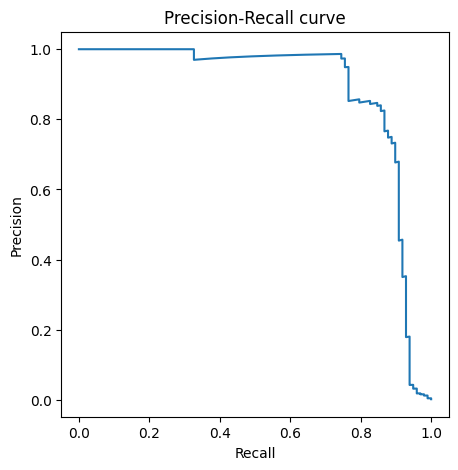

In [29]:
result_cb = evaluate_model(model_cb, X_test, y_test)

In [30]:
# Saving the model with the best performance
model_cb.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"CatBoost-{datetime.now().strftime('%Y%m%d')}"))

# Example to load model
# loaded_model_xgb = cb.CatBoostClassifier()
# loaded_model_xgb.load_model('model_name')

In [31]:
def objective_lgb(
        trial,
        eval_metric='binary_logloss', 
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3,
):
    
    dtrain = lgb.Dataset(x_train, label=y_train)

    pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "objective": "binary",
        "metric": eval_metric,
        "verbosity": -1,
        "boosting_type": "gbdt",
        # "max_depth":trial.suggest_int("max_depth", 2, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'device':'gpu',
        "scale_pos_weight":pos_weight
    }


    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, f"valid {eval_metric}")

    lgb_cv_results = lgb.cv(
        params=params,
        train_set=dtrain,
        return_cvbooster=True,
        num_boost_round=10000,
        callbacks=[pruning_callback, early_stopping(100)],
        nfold=n_folds,
        stratified=True,
        seed=seed
    )


    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("iterations", lgb_cv_results["cvbooster"].best_iteration)


    best_score = lgb_cv_results[f'valid {eval_metric}-mean'][-1]
    return best_score

In [32]:
study_lgb = optimize_objective(
    objective=objective_lgb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 20:14:39,993] A new study created in memory with name: no-name-1a597b0b-bae5-4cb4-9ffa-9bdc0e992665


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:14:44,354] Trial 0 finished with value: 0.09508218112517436 and parameters: {'lambda_l1': 0.0033984171703750807, 'lambda_l2': 7.6254290610499836e-06, 'num_leaves': 124, 'feature_fraction': 0.7906442109670058, 'bagging_fraction': 0.5942223641535316, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 0 with value: 0.09508218112517436.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.0950822 + 0.00727069
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:14:46,384] Trial 1 finished with value: 0.13158187788650585 and parameters: {'lambda_l1': 0.020222685479846465, 'lambda_l2': 1.4586433070359072e-06, 'num_leaves': 49, 'feature_fraction': 0.46435207431928494, 'bagging_fraction': 0.698920000453743, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 0 with value: 0.09508218112517436.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.131582 + 0.00603021
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:14:55,879] Trial 2 finished with value: 0.09215951607402133 and parameters: {'lambda_l1': 0.969208409081969, 'lambda_l2': 9.891125739269161e-05, 'num_leaves': 185, 'feature_fraction': 0.8378068519278792, 'bagging_fraction': 0.6899256887778367, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 2 with value: 0.09215951607402133.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.0921595 + 0.00400202
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:15:07,182] Trial 3 finished with value: 0.07480997348765428 and parameters: {'lambda_l1': 0.03186012804757693, 'lambda_l2': 5.789458924106569e-07, 'num_leaves': 34, 'feature_fraction': 0.8320002694938353, 'bagging_fraction': 0.6448409141567651, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 3 with value: 0.07480997348765428.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.07481 + 0.00682885
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:15:17,205] Trial 4 finished with value: 0.056561832261852886 and parameters: {'lambda_l1': 7.640942728943817, 'lambda_l2': 0.0024939192322730548, 'num_leaves': 47, 'feature_fraction': 0.6346570870452377, 'bagging_fraction': 0.9929591789547388, 'bagging_freq': 7, 'min_child_samples': 99}. Best is trial 4 with value: 0.056561832261852886.


Early stopping, best iteration is:
[259]	cv_agg's valid binary_logloss: 0.0565618 + 0.00438059


[I 2023-10-12 20:15:18,819] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:15:22,134] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:15:22,783] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:15:23,610] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:15:26,902] Trial 9 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:15:37,952] Trial 10 finished with value: 0.005349812979508762 and parameters: {'lambda_l1': 8.179592279841776, 'lambda_l2': 2.0577064346263154, 'num_leaves': 248, 'feature_fraction': 0.6496383773848371, 'bagging_fraction': 0.43632445660922836, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 10 with value: 0.005349812979508762.


Early stopping, best iteration is:
[391]	cv_agg's valid binary_logloss: 0.00534981 + 0.000465136
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:15:48,739] Trial 11 finished with value: 0.005047002803532579 and parameters: {'lambda_l1': 4.8575561281344095, 'lambda_l2': 1.8273868979127803, 'num_leaves': 251, 'feature_fraction': 0.6516639473088195, 'bagging_fraction': 0.41809665449381483, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 11 with value: 0.005047002803532579.


Early stopping, best iteration is:
[410]	cv_agg's valid binary_logloss: 0.005047 + 0.000336478
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:16:07,328] Trial 12 finished with value: 0.0038827678651461675 and parameters: {'lambda_l1': 3.473973569834662, 'lambda_l2': 9.540737723238685, 'num_leaves': 256, 'feature_fraction': 0.6978217644669494, 'bagging_fraction': 0.40289899439498283, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 12 with value: 0.0038827678651461675.


Early stopping, best iteration is:
[419]	cv_agg's valid binary_logloss: 0.00388277 + 0.000558966
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:16:15,729] Trial 13 finished with value: 0.003569466566184296 and parameters: {'lambda_l1': 6.122532731667678e-08, 'lambda_l2': 5.408465842312135, 'num_leaves': 256, 'feature_fraction': 0.7002772019557343, 'bagging_fraction': 0.4071011410245907, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 13 with value: 0.003569466566184296.


Early stopping, best iteration is:
[188]	cv_agg's valid binary_logloss: 0.00356947 + 0.00046235
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:16:30,258] Trial 14 finished with value: 0.0035050288570395026 and parameters: {'lambda_l1': 2.496569088663017e-08, 'lambda_l2': 7.491290195694917, 'num_leaves': 224, 'feature_fraction': 0.7465445951598932, 'bagging_fraction': 0.4695667893426089, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 14 with value: 0.0035050288570395026.


Early stopping, best iteration is:
[156]	cv_agg's valid binary_logloss: 0.00350503 + 0.000401491
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:16:44,767] Trial 15 pruned. Trial was pruned at iteration 102.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:16:50,734] Trial 16 pruned. Trial was pruned at iteration 102.
[I 2023-10-12 20:16:51,397] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:16:52,579] Trial 18 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:17:01,060] Trial 19 finished with value: 0.0036887105487569665 and parameters: {'lambda_l1': 1.835353110289932e-07, 'lambda_l2': 7.513412940851278, 'num_leaves': 228, 'feature_fraction': 0.5516212621442593, 'bagging_fraction': 0.4051380373176238, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 14 with value: 0.0035050288570395026.


Early stopping, best iteration is:
[217]	cv_agg's valid binary_logloss: 0.00368871 + 0.000824036


[I 2023-10-12 20:17:01,574] Trial 20 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:17:16,126] Trial 21 finished with value: 0.003499050922708519 and parameters: {'lambda_l1': 9.077360906702357e-08, 'lambda_l2': 9.474463112665847, 'num_leaves': 230, 'feature_fraction': 0.5330244445352659, 'bagging_fraction': 0.4269856773793733, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 21 with value: 0.003499050922708519.


Early stopping, best iteration is:
[218]	cv_agg's valid binary_logloss: 0.00349905 + 0.000483991
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:17:17,650] Trial 22 pruned. Trial was pruned at iteration 10.
[I 2023-10-12 20:17:18,876] Trial 23 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:17:21,968] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:17:23,329] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:17:23,955] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:17:24,445] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:17:26,629] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:17:27,867] Trial 29 pruned. Trial was pruned at iteration 0.


Number of finished trials:  30
Best trial:
  Value: 0.003499050922708519
  Params: 
    lambda_l1: 9.077360906702357e-08
    lambda_l2: 9.474463112665847
    num_leaves: 230
    feature_fraction: 0.5330244445352659
    bagging_fraction: 0.4269856773793733
    bagging_freq: 4
    min_child_samples: 16


In [44]:
optuna.visualization.plot_optimization_history(study_lgb)

In [34]:
def create_fit_lgb(study, x, y):

    model = lgb.LGBMClassifier(
        **study.best_params, 
        n_estimators = study.best_trial.user_attrs['iterations'],
        verbosity=-1
    )
    model.fit(x, y)

    return model

model_lgb = create_fit_lgb(study_lgb, X_train, y_train)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.80      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8844

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.986111,0.724490,27,1,71,56863
1,0.2,0.973684,0.755102,24,2,74,56862
2,0.3,0.962025,0.775510,22,3,76,56861
3,0.4,0.962500,0.785714,21,3,77,56861
4,0.5,0.962963,0.795918,20,3,78,56861
5,0.6,0.963855,0.816327,18,3,80,56861
6,0.7,0.942529,0.836735,16,5,82,56859
7,0.8,0.942529,0.836735,16,5,82,56859
8,0.9,0.892473,0.846939,15,10,83,56854


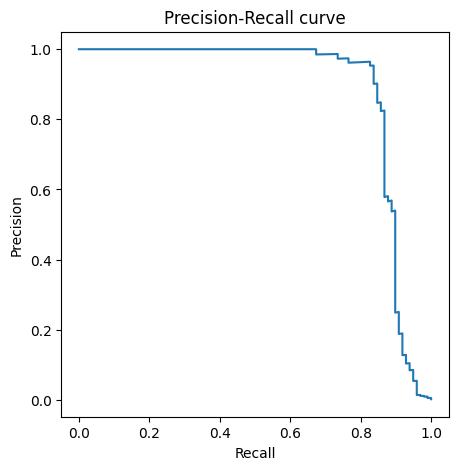

In [35]:
result_lgb = evaluate_model(model_lgb, X_test, y_test)

In [36]:
model_lgb.booster_.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"LGB-{datetime.now().strftime('%Y%m%d')}.txt"))

# Example to load model
# loaded_model_lgb = lgb.Booster(model_file='mode.txt')

### Model comparison

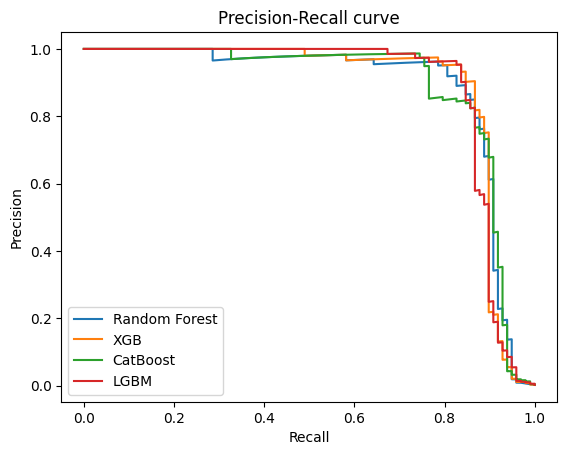

In [37]:
results= {
    'Random Forest':result_rf,
    'XGB':result_xgb,
    'CatBoost':result_cb,
    'LGBM':result_lgb
}

f,ax = plt.subplots(1)

for result in results.items():
    ax.plot(result[1][2], result[1][3], label=result[0])

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')

ax.legend(loc='lower left')
plt.show()

In [38]:
aucpr_dict = dict()
for result in results.items():
    aucpr_dict[result[0]] = [result[1][1]]

aucpr_df = pd.DataFrame(aucpr_dict).T
aucpr_df.columns = ['AUCPR score']
aucpr_df

,AUCPR score
Random Forest,0.883348
XGB,0.886406
CatBoost,0.883897
LGBM,0.884416


In [39]:
def create_df(results_dict, relevant_cols):
    # Initialize an empty dataframe
    merged_df = pd.DataFrame()

    # Iterate through the list of tuples and merge the dataframes
    for name, df in [(result[0], result[1][0]) for result in results_dict.items()]:
        if merged_df.empty:
            merged_df = df[['threshold']].copy()
            merged_df.columns = pd.MultiIndex.from_tuples([('', col) for col in merged_df.columns])
        
        df = df[relevant_cols]
        df.columns = pd.MultiIndex.from_tuples([(name, col) for col in df.columns])
        merged_df = merged_df.merge(df, left_index=True, right_index=True, how='outer')
        
    return merged_df

create_df(results_dict=results, relevant_cols=['precision','recall'])    

Random Forest                 XGB            CatBoost            \
  threshold     precision    recall precision    recall precision    recall   
0       0.1      0.957143  0.683673  0.952381  0.816327  0.855556  0.785714   
1       0.2      0.961039  0.755102  0.931818  0.836735  0.847826  0.795918   
2       0.3      0.951220  0.795918  0.912088  0.846939  0.847826  0.795918   
3       0.4      0.910112  0.826531  0.902174  0.846939  0.843750  0.826531   
4       0.5      0.864583  0.846939  0.903226  0.857143  0.840000  0.857143   
5       0.6      0.850000  0.867347  0.825243  0.867347  0.831683  0.857143   
6       0.7      0.809524  0.867347  0.796296  0.877551  0.801887  0.867347   
7       0.8      0.761062  0.877551  0.739496  0.897959  0.743590  0.887755   
8       0.9      0.666667  0.897959  0.637681  0.897959  0.640288  0.908163   

       LGBM            
  precision    recall  
0  0.986111  0.724490  
1  0.973684  0.755102  
2  0.962025  0.775510  
3  0.962500  0.785714  
4  0.962963  0.795918  
5  0.963855  0.816327  
6  0.942529  0.836735  
7  0.942529  0.836735  
8  0.892473  0.846939

In [40]:
create_df(results_dict=results, relevant_cols=['FN','FP','TP','TN'])    

Random Forest                XGB                CatBoost          \
  threshold            FN  FP  TP     TN  FN  FP  TP     TN       FN  FP  TP   
0       0.1            31   3  67  56861  18   4  80  56860       21  13  77   
1       0.2            24   3  74  56861  16   6  82  56858       20  14  78   
2       0.3            20   4  78  56860  15   8  83  56856       20  14  78   
3       0.4            17   8  81  56856  15   9  83  56855       17  15  81   
4       0.5            15  13  83  56851  14   9  84  56855       14  16  84   
5       0.6            13  15  85  56849  13  18  85  56846       14  17  84   
6       0.7            13  20  85  56844  12  22  86  56842       13  21  85   
7       0.8            12  27  86  56837  10  31  88  56833       11  30  87   
8       0.9            10  44  88  56820  10  50  88  56814        9  50  89   

         LGBM                 
      TN   FN  FP  TP     TN  
0  56851   27   1  71  56863  
1  56850   24   2  74  56862  
2  56850   22   3  76  56861  
3  56849   21   3  77  56861  
4  56848   20   3  78  56861  
5  56847   18   3  80  56861  
6  56843   16   5  82  56859  
7  56834   16   5  82  56859  
8  56814   15  10  83  56854

In [52]:
# Create a scatter plot for each dataset
fig = go.Figure()


for result in results.items():
    # Create custom hover text with the additional information
    hover_text = [f"{result[0]} at {info:.1f} threshold" for info in result[1][0]['threshold']]

    fig.add_trace(go.Scatter(
        x=result[1][0]['FP'], 
        y=result[1][0]['FN'], 
        mode='markers', 
        name=result[0],
        text=hover_text  # Assign the custom hover text here
    ))

    fig.add_shape(type="rect",
    xref="x", yref="y",
    x0=0, y0=0,
    x1=50, y1=15,
    fillcolor="green",
    opacity=0.1
    )


# Customize the layout, axis labels, and size
fig.update_layout(
    title='Scatter Plot',
    xaxis_title='FP - incorrectly classified as fraudulent',
    yaxis_title='FN- incorrectly classified as nonfraudulent',
    width=800,
    height=600
)

# Show the plot
fig.show()


### Conclusion:

We have achieved satisfactory predictive performance using all four models, despite the extremely imbalanced dataset.

I've highlighted the promising results on the above plot with a green rectangle based on my intuition. However, our ultimate decision regarding model selection and the threshold could depend on several crucial factors. For example, in a real-world scenario, the cost of misclassifying a fraudulent case as non-fraudulent may be significantly higher than misclassifying a non-fraudulent case as fraudulent. In such cases, further fine-tuning of the models is necessary, with a greater emphasis on recall rather than the overall AUCPR score."